In [1]:
import numpy as np
import torch
import msgpack
import matplotlib.pyplot as plt
import json
from tqdm import trange
from utils import *

In [2]:
def grid_to_point_cloud(grid: torch.Tensor, threshold: float = 0.01) -> torch.Tensor:
    """
    Convert the density grid to the point cloud
    Args:
        grid (torch.Tensor): density grid
        threshold (float): threshold value to determine the point cloud
    Returns:
        Point cloud (torch.Tensor): point cloud with shape (N, 4), means (x, y, z, 1)
    """
    x, y, z = torch.where(grid > threshold)
    #density = grid[x, y, z]
    point_cloud = torch.stack([x, y, z], dim = 1)
    point_cloud_4d = torch.cat([point_cloud, torch.ones((point_cloud.shape[0], 1))], dim = 1)
    return point_cloud_4d

def reduce_grid(input_grid: torch.Tensor) -> torch.Tensor:
    """
    Scale the density grid with scale 2
    """
    shape_x, shape_y, shape_z = input_grid.shape
    grid_half = torch.zeros((shape_x // 2, shape_y // 2, shape_z // 2))
    for i in range(2):
        for j in range(2):
            for k in range(2):
                grid_half += input_grid[i::2, j::2, k::2]
    grid_half /= 8
    return grid_half

def load_density_grid_to_point_cloud(path: str, num_of_scale: int = 2)  -> torch.Tensor:
    """
    Load the density grid, and transform it to the point cloud
    Args:
        path (str): path to the density grid file
        num_of_scale: number of scale to reduce the density grid. The final density grid will be 128 / (2 ** num_of_scale)
    Returns:
        Point cloud (torch.Tensor): point cloud with shape (N, 4), means (x, y, z, density)
    """
    with open(path, 'rb') as f:
        unpacker = msgpack.Unpacker(f, raw = False, max_buffer_size = 0)
        config = next(unpacker)
    grid_raw = torch.tensor(np.clip(
        np.frombuffer(config["snapshot"]["density_grid_binary"],dtype=np.float16).astype(np.float32),
        0, 1))
    grid = torch.zeros([128 * 128 * 128], dtype = torch.float32)
    x_id, y_id, z_id = inv_morton_naive(torch.arange(0, 128**3, 1))
    grid[x_id * 128 * 128 + y_id * 128 + z_id] = grid_raw

    grid = grid.reshape([128, 128, 128])
    
    for _ in range(num_of_scale):
        grid = reduce_grid(grid)
    
    return grid_to_point_cloud(grid)


In [3]:
def convert_coordinate(input_points: torch.Tensor, resolution: int = 32) -> torch.Tensor:
    """
    Convert the points in NeRF Coordinate to NGP coordinate
    Args:
        input_points: the points in NeRF coordinates
        resolution: Resolution of density grid
    Returns:
        output_points: the points in Our coordinate
    """
    x_raw,y_raw,z_raw = input_points[..., 0], input_points[..., 1], input_points[..., 2]
    x_normalized, y_normalized, z_normalized = x_raw.float() / resolution, y_raw.float() / resolution, z_raw.float() / resolution
    #x,y,z = (1/0.66) * (2 * z_normalized - 1), (1/0.66) * (2 * x_normalized - 1), (1/0.66) * (2 * y_normalized - 1)
    x, y, z = 3 * z_normalized - 1.5, 3 * x_normalized - 1.5, 3 * y_normalized - 1.5
    points_converted = torch.stack([x, y, z], dim = -1)
    return torch.cat([points_converted, torch.ones((points_converted.shape[0], 1))], dim = 1)

def get_w2c_matrix(c2w: np.ndarray) -> torch.Tensor:
    """
    Get the world to camera matrix from the camera to world matrix
    Args:
        c2w: camera to world matrix
    Returns:
        w2c: world to camera matrix
    """
    w2c = c2w
    w2c[..., 1] *= -1
    w2c[..., 2] *= -1
    w2c = np.linalg.inv(w2c)
    w2c = w2c[:3]
    
    return torch.tensor(w2c, dtype = torch.float32)

def get_K_matrix(focal: float | tuple, resolution: int | tuple) -> torch.Tensor:
    """
    Get the camera matrix
    Args:
        focal: focal length of the camera. int for same focal length in x and y, tuple for different focal length
        resolution: resolution of the camera, int for same resolution in x and y, tuple for different resolution
    Returns:
        K: camera matrix
    """
    if isinstance(focal, float):
        focal = (focal, focal)
    if isinstance(resolution, int):
        resolution = (resolution, resolution)
    fx, fy = focal
    cx, cy = resolution[0] / 2, resolution[1] / 2
    return torch.tensor([[fx, 0, cx], [0, fy, cy], [0, 0, 1]], dtype = torch.float32)

def project_and_rasterization(points: torch.Tensor, w2c: torch.Tensor, K: torch.Tensor, resolution: int = 800, sphere_radius: float = 8.0, bound: float = 32.0) -> torch.Tensor:
    """
    Do Projection and Rasterization with the given points and camera parameters
    Args:
        points: the points in Our coordinates
        w2c: world to camera matrix
        K: camera matrix
        resolution: resolution of the image
        sphere_radius: radius of the sphere
        bound: bound of the projected circle
    Returns:
        image: the rasterized image
    """
    points_in_view_space = torch.matmul(w2c, points.T).T
    points_in_pixel_space = torch.matmul(K, points_in_view_space.T).T
    
    # Do Projection
    points_in_projection_space_xy = points_in_pixel_space[..., :2] / points_in_pixel_space[..., 2:]
    points_in_projection_space_z = points_in_pixel_space[..., 2]
    
    # Do Rasterization
    image = torch.zeros([resolution, resolution])
    near_depth = torch.zeros([resolution, resolution], dtype = torch.float32) + 1e6
    far_depth = torch.zeros([resolution, resolution], dtype = torch.float32)
    
    x, y = torch.round(points_in_projection_space_xy[..., 0]), torch.round(points_in_projection_space_xy[..., 1])
    z = points_in_projection_space_z
    x = x[(x >= 0) & (x < resolution)]
    y = y[(y >= 0) & (y < resolution)]
    
    z_normalized = (z - z.min()) / (z.max() - z.min())
    #scale_factor = 1 - z_normalized
    ## Rasterization
    
    radius_fp = sphere_radius / z_normalized
    print(radius_fp[:10], z[:10])
    radius_fp[torch.isinf(radius_fp) | (radius_fp > bound)] = bound
    radius = torch.round(radius_fp).type(torch.int32)
    for i in trange(x.shape[0]):
        for j in range(-radius[i], radius[i] + 1):
            for k in range(-radius[i], radius[i] + 1):
                if (x[i] + j < resolution and x[i] + j >= 0 and y[i] + k < resolution and y[i] + k >= 0):
                    index_x = int(y[i]+k)-1
                    index_y = int(x[i]+j)-1
                    image[index_x, index_y] = 1
                    # Update near and far depth
                    near_depth[index_x, index_y] = min(near_depth[index_x, index_y], z[i] - radius_fp[i])
                    far_depth[index_x, index_y] = max(far_depth[index_x, index_y], z[i] + radius_fp[i])
    
    return image, near_depth, far_depth

In [4]:
resolution = 800
num_of_scale = 0
resolution_of_grid = 128 / (2 ** num_of_scale)

with open(f"./example_data.json", "r") as f:
    meta = json.load(f)
m_Camera_Angle_X = float(meta["camera_angle_x"])
m_C2W = np.array(meta["frames"][15]["transform_matrix"]).reshape(4, 4)

point_cloud_raw = load_density_grid_to_point_cloud("./data/lego.msgpack", num_of_scale = num_of_scale)
point_cloud = convert_coordinate(point_cloud_raw, resolution=resolution_of_grid)
w2c = get_w2c_matrix(m_C2W)
focal = 0.5 * resolution / np.tan(0.5 * (m_Camera_Angle_X))
K = get_K_matrix(focal, resolution)
image, near_depth, far_depth = project_and_rasterization(point_cloud, w2c, K, resolution, sphere_radius = 4, bound = 8)
#image, near_depth, far_depth = project_and_rasterization(point_cloud, w2c, K, resolution, sphere_radius = 1, bound = 2)

tensor([6.1859, 6.1227, 6.0609, 6.0003, 5.9408, 5.8826, 5.8255, 5.7695, 5.7145,
        5.6606]) tensor([4.3958, 4.4091, 4.4224, 4.4358, 4.4491, 4.4624, 4.4758, 4.4891, 4.5024,
        4.5158])


100%|██████████| 68330/68330 [10:49<00:00, 105.24it/s]


# 可视化与测试

## 投影结果的可视化

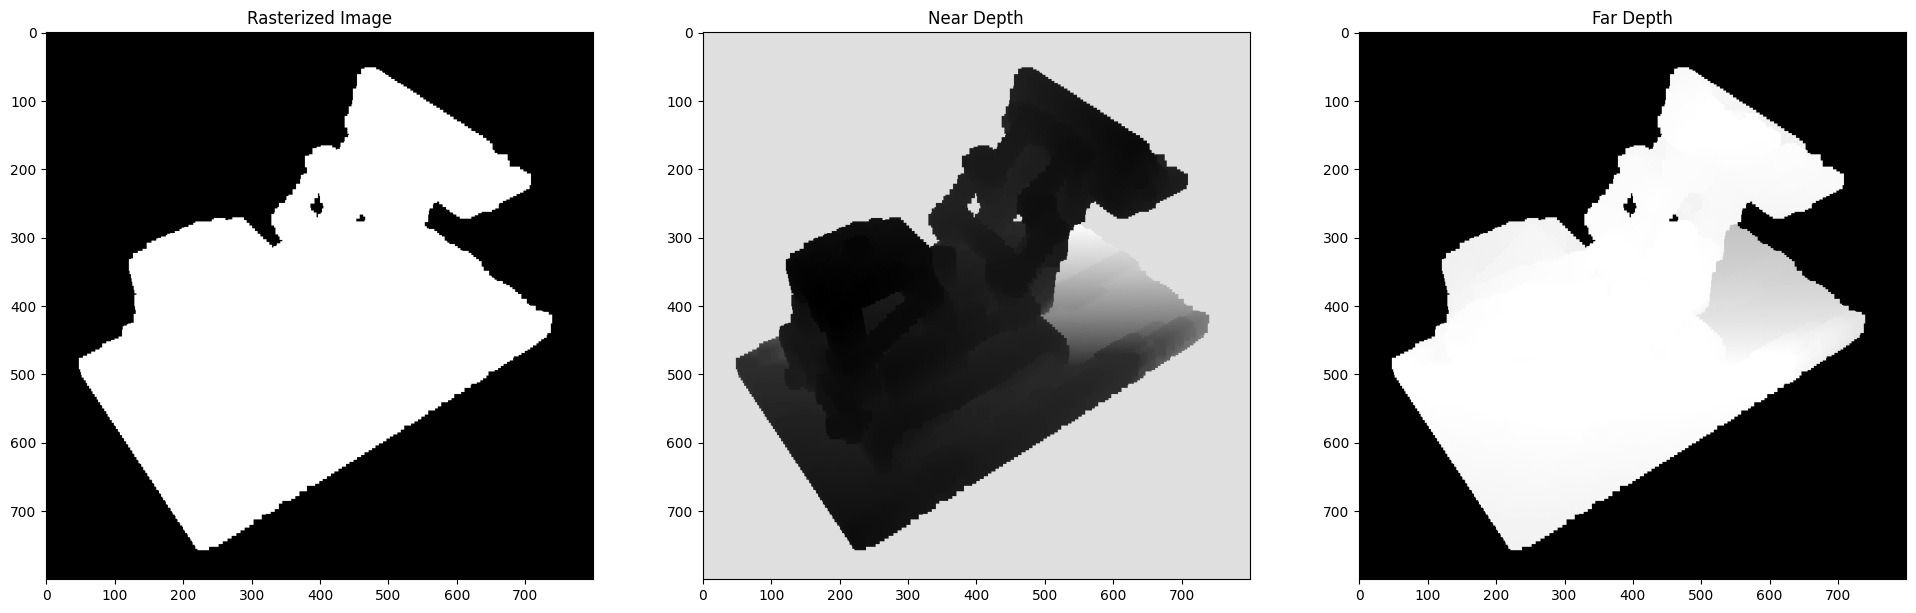

In [5]:
# Visualize the result
fig = plt.figure(figsize=(24, 8))
fig.add_subplot(1, 3, 1)
plt.imshow(image, cmap = "gray")
plt.title("Rasterized Image")
fig.add_subplot(1, 3, 2)
# Show Near Depth
near_depth[near_depth == 1e6] = 0
plt.imshow(near_depth, cmap = "gray")
plt.title("Near Depth")
fig.add_subplot(1, 3, 3)
# Show Far Depth
plt.imshow(far_depth, cmap = "gray")
plt.title("Far Depth")
plt.show()

near_depth_out = near_depth / 3
near_depth_out[near_depth_out == 0] = 1e3
far_depth_out = far_depth / 3
far_depth_out[far_depth_out == 0] = 1e3
np.savetxt("near_depth.txt", (near_depth_out).numpy())
np.savetxt("far_depth.txt", (far_depth_out).numpy())

## Ray Tracing 得到的 Reference

(800, 800) 1.0 0.0


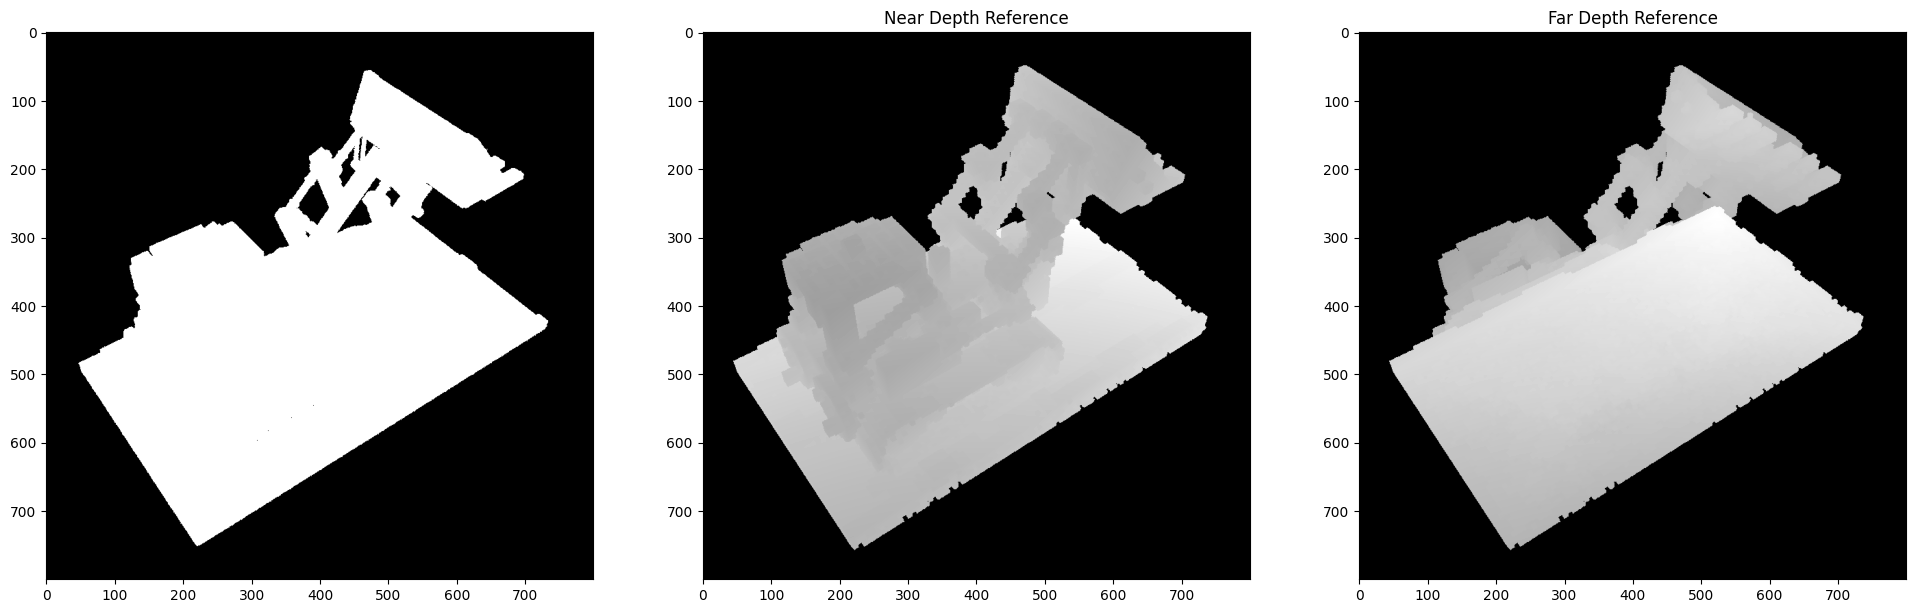

In [6]:
near_depth_ref = np.loadtxt("./near.txt")
near_depth_ref[near_depth_ref == 1000] = 0

far_depth_ref = np.loadtxt("./far.txt")

# For ref image, get nonzero point
ref_image = plt.imread("./Ref_Lego_15.png")
ref_image = ref_image[...,:3].mean(axis = -1)
print(ref_image.shape, ref_image.max(), ref_image.min())
ref_image = (ref_image > 0).astype(np.float32)

plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.imshow(ref_image, cmap = "gray")
plt.subplot(1, 3, 2)
plt.imshow(near_depth_ref.T, cmap = "gray")
plt.title("Near Depth Reference")
plt.subplot(1, 3, 3)
plt.imshow(far_depth_ref.T, cmap = "gray")
plt.title("Far Depth Reference")
plt.show()

np.savetxt("near_depth_ref.txt", near_depth_ref.T)
np.savetxt("far_depth_ref.txt", far_depth_ref.T)

(800, 800) float32


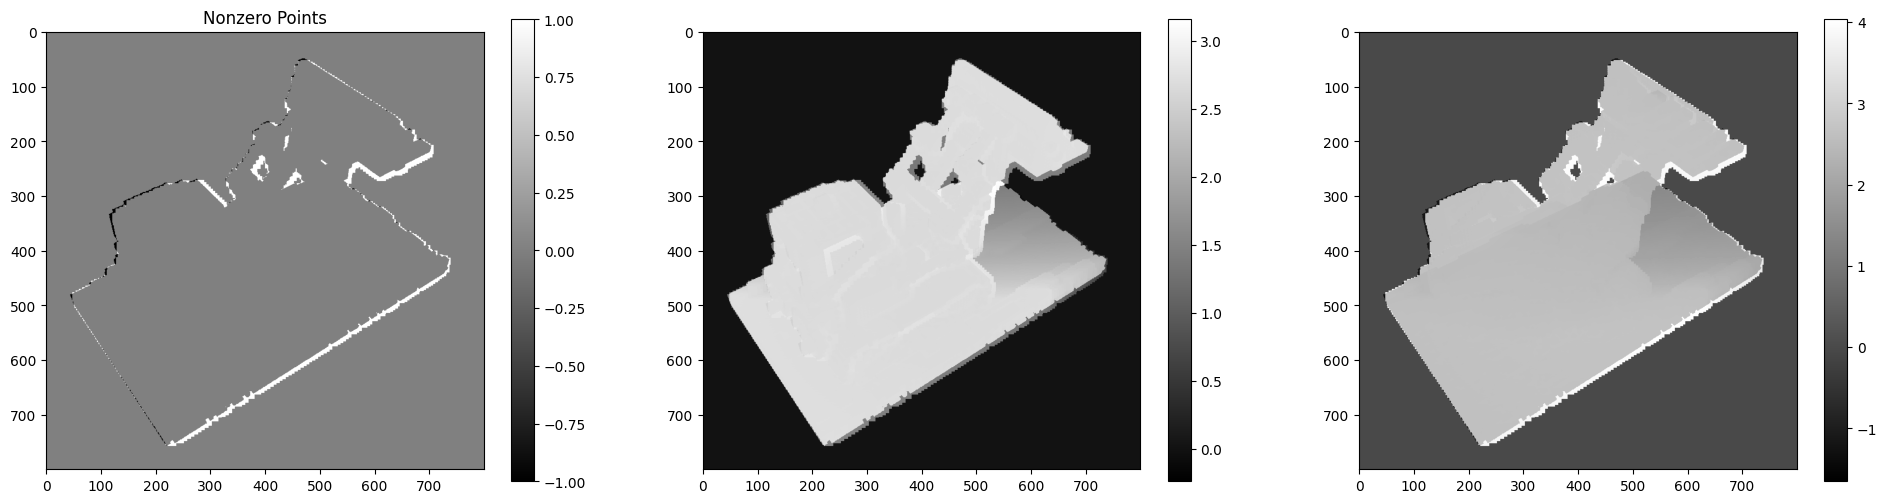

In [7]:
import cv2
# Do reshape
ref_ours = (near_depth_ref.T > 0).astype(np.float32)
print(ref_ours.shape, ref_ours.dtype)

Diff_of_image = (image - cv2.resize(ref_ours, image.shape))
plt.figure(figsize = (24, 6))
plt.subplot(1,3,1)
bar = plt.imshow(Diff_of_image, cmap = "gray")
plt.colorbar(bar)
plt.title("Nonzero Points")
plt.subplot(1,3,2)
# Show The Diff of near
diff_of_near = cv2.resize(near_depth_ref.T, (resolution, resolution)) - near_depth.numpy()/3
bar = plt.imshow(diff_of_near, cmap = "gray")
plt.colorbar(bar)
plt.subplot(1,3,3)
diff_of_far = far_depth.numpy()/3 - cv2.resize(far_depth_ref.T, (resolution, resolution))
bar = plt.imshow(diff_of_far, cmap = "gray")
plt.colorbar(bar)
plt.show()

结果对比

In [8]:
scale = near_depth[400, 400] / near_depth_ref.T[400, 400]
print(near_depth[400:405, 400:405] / 3)
print(near_depth_ref.T[400:405, 400:405])
print("=======================================================")
print(far_depth[400:405, 400:405] / 3)
print(far_depth_ref.T[400:405, 400:405])

tensor([[-1.4511, -1.4511, -1.4511, -1.4511, -1.4511],
        [-1.4543, -1.4543, -1.4543, -1.4543, -1.4511],
        [-1.4556, -1.4556, -1.4556, -1.4556, -1.4556],
        [-1.4556, -1.4556, -1.4556, -1.4556, -1.4556],
        [-1.4556, -1.4556, -1.4556, -1.4556, -1.4556]])
[[1.27874 1.28044 1.25337 1.28213 1.28382]
 [1.19925 1.28213 1.28213 1.28382 1.28551]
 [1.19755 1.19755 1.28382 1.28551 1.28551]
 [1.19755 1.19755 1.19755 1.28551 1.2872 ]
 [1.19586 1.19586 1.19586 1.19586 1.28889]]
tensor([[4.0336, 4.0336, 4.0336, 4.0336, 4.0336],
        [4.0336, 4.0336, 4.0336, 4.0336, 4.0336],
        [4.0336, 4.0336, 4.0336, 4.0336, 4.0336],
        [4.0336, 4.0336, 4.0336, 4.0336, 4.0336],
        [4.0336, 4.0336, 4.0336, 4.0336, 4.0336]])
[[1.52739 1.52739 1.52739 1.52908 1.53077]
 [1.52739 1.52739 1.52908 1.53077 1.53246]
 [1.52739 1.52908 1.53077 1.53246 1.53415]
 [1.52908 1.53077 1.53246 1.53246 1.53415]
 [1.53077 1.53246 1.53246 1.53415 1.53415]]


53 465
50 467


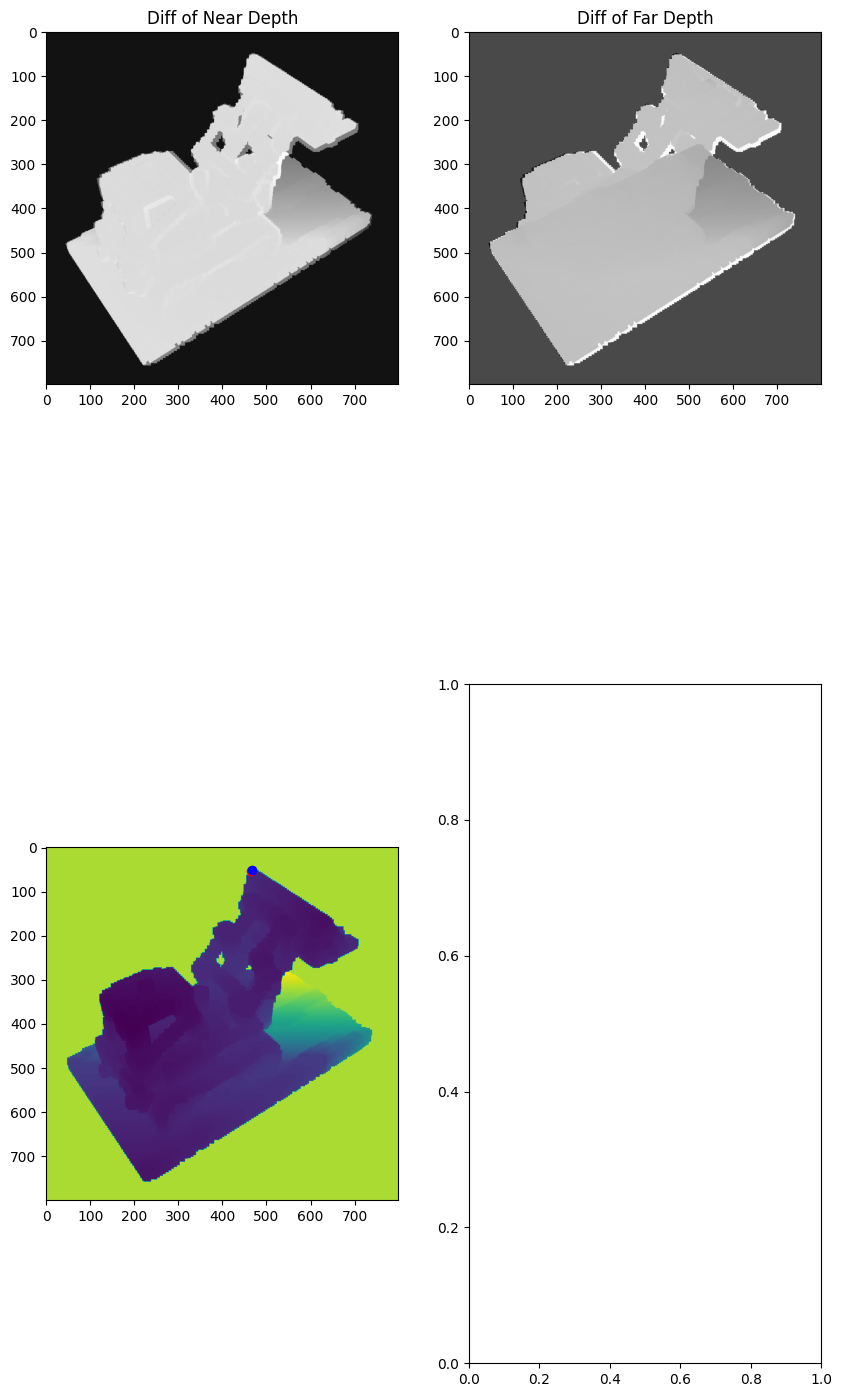

In [9]:
# Show Diff of ref and our result
plt.figure(figsize=(10, 30))
plt.subplot(3, 2, 1)
plt.imshow((-near_depth / 3 + near_depth_ref.T), cmap = "gray")
plt.title("Diff of Near Depth")
plt.subplot(3, 2, 2)
plt.imshow((far_depth / 3 - far_depth_ref.T), cmap = "gray")
plt.title("Diff of Far Depth")
plt.subplot(3, 2, 3)
# Get the first location
for i1 in range(800):
    flag = False
    for j1 in range(800):
        if near_depth[i1, j1] != 0:
            print(i1, j1)
            flag = True
            break
    if flag:
        break
for i2 in range(800):
    flag = False
    for j2 in range(800):
        if near_depth_ref.T[i2, j2] != 0:
            print(i2, j2)
            flag = True
            break
    if flag:
        break
plt.imshow(near_depth)
# Draw the first location
plt.scatter(j1, i1, c = 'r')
plt.scatter(j2, i2, c = 'b')
plt.subplot(3, 2, 4)
plt.show()

## 点数展示

(800, 800)
0.0 111.0
640000
400854 0.626334375
202894 0.317021875
[239146, 134571, 36252, 13004, 4790, 1642, 673, 263, 90, 43, 24, 20, 14, 10, 0, 0]


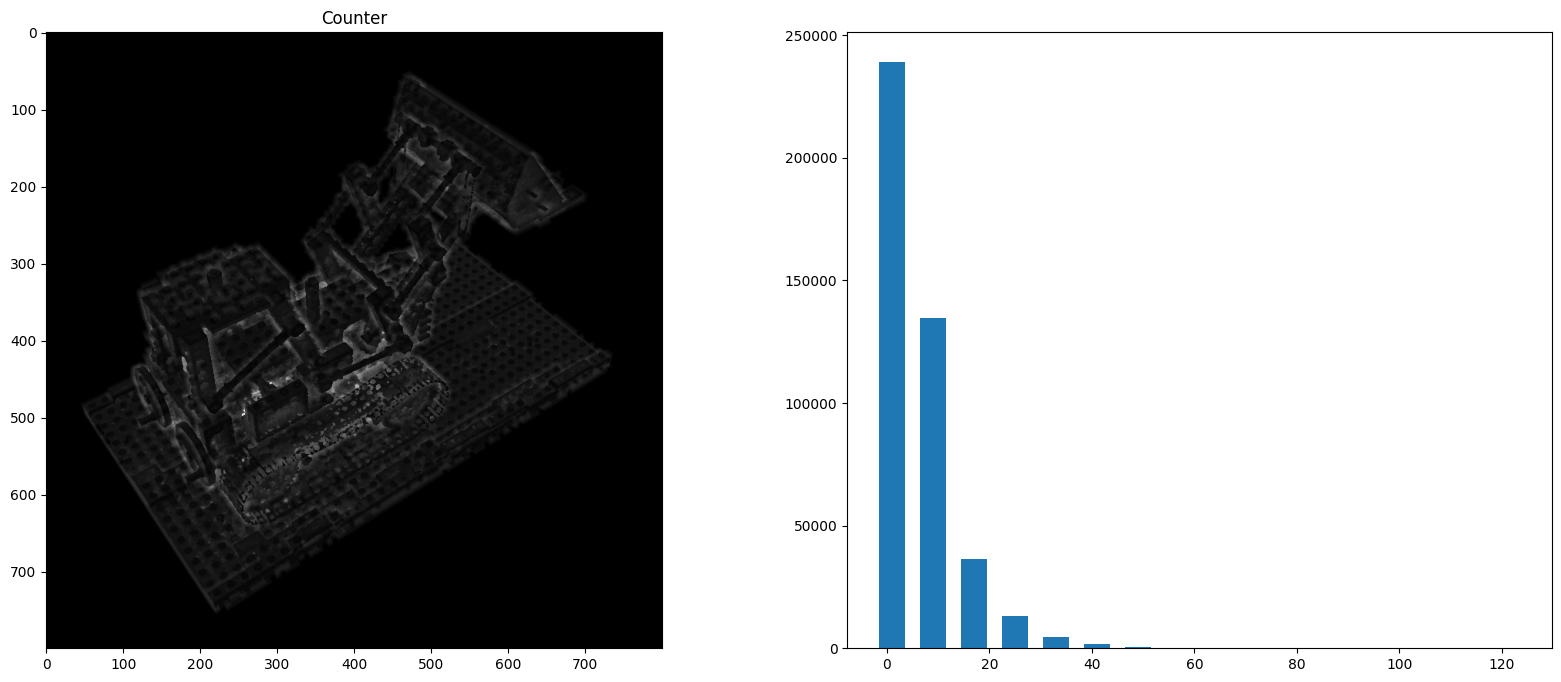

In [10]:
Counter = np.loadtxt("./counter.txt").T
print(Counter.shape)
print(Counter.min(), Counter.max())
print("==========")
print(800*800)
print(np.count_nonzero(Counter == 0), np.count_nonzero(Counter == 0) / (800*800))
print(np.count_nonzero(((Counter > 0) & (Counter <= 16))), np.count_nonzero(((Counter > 0) & (Counter <= 16))) / (800*800))
counters = [np.count_nonzero(Counter > num) for num in range(0, 128, 8)]
# print(np.count_nonzero(Counter > 8), np.count_nonzero(Counter > 8) / (800*800))
# print(np.count_nonzero(Counter > 16), np.count_nonzero(Counter > 16) / (800*800))
# print(np.count_nonzero(Counter > 24), np.count_nonzero(Counter > 24) / (800*800))
# print(np.count_nonzero(Counter > 32), np.count_nonzero(Counter > 32) / (800*800))
# print(np.count_nonzero(Counter > 48), np.count_nonzero(Counter > 48) / (800*800))
print(counters)

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.imshow(Counter, cmap = "gray")
plt.title("Counter")
plt.subplot(1,2,2)
# Draw counters
plt.bar(np.arange(1, 128, 8),counters, width = 5)
plt.show()